In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import proplot as pplot
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cmaps
import cnmaps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from cnmaps import get_map, draw_map, clip_contours_by_map
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

import rioxarray
import geopandas
import pyhomogeneity as hg
from shapely.geometry import mapping

import os
os.chdir('/Users/zeqinhuang/Documents/paper/HW_track')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# calculate summer historical constructed analogue time series 
dynamic_t2m_ano_D1 = xr.open_dataarray('data/dynamic_t2m_historical/dynamic_t2m_era5_' + 'D1' + 'SLP.nc')
dynamic_t2m_ano_D2 = xr.open_dataarray('data/dynamic_t2m_historical/dynamic_t2m_era5_' + 'D2' + 'SLP.nc')
dynamic_t2m_ano_D3 = xr.open_dataarray('data/dynamic_t2m_historical/dynamic_t2m_era5_' + 'D3' + 'SLP.nc')
new_lon = dynamic_t2m_ano_D1.lon
new_lat = dynamic_t2m_ano_D1.lat
target_shape = dynamic_t2m_ano_D1.shape
dynamic_t2m_ano_D2_new = np.empty(target_shape[1:])
dynamic_t2m_ano_D3_new = np.empty(target_shape[1:])

for i in range(target_shape[0]):
    dynamic_t2m_ano_D2_new[:,:,:,5:36,10:71] = dynamic_t2m_ano_D2.values[i]
    dynamic_t2m_ano_D2_new = xr.DataArray(
        data=dynamic_t2m_ano_D2_new,
        coords=[dynamic_t2m_ano_D1.dist_func,dynamic_t2m_ano_D1.every_other_5day,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
        dims = ['dist_func','every_other_5day','target_time','lat','lon'])
    dynamic_t2m_ano_D3_new[:,:,:,10:31,20:61] = dynamic_t2m_ano_D3.values[i]
    dynamic_t2m_ano_D3_new = xr.DataArray(
        data=dynamic_t2m_ano_D3_new,
        coords=[dynamic_t2m_ano_D1.dist_func,dynamic_t2m_ano_D1.every_other_5day,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
        dims = ['dist_func','every_other_5day','target_time','lat','lon'])

    dynamic_t2m_ano_all = np.empty((target_shape[1]*target_shape[2]*3,) + target_shape[-3:])
    dynamic_t2m_ano_all[:20] = dynamic_t2m_ano_D1.values[i].reshape((20,)+target_shape[-3:])
    dynamic_t2m_ano_all[20:40] = dynamic_t2m_ano_D2_new.values.reshape((20,)+target_shape[-3:])
    dynamic_t2m_ano_all[40:] = dynamic_t2m_ano_D3_new.values.reshape((20,)+target_shape[-3:])
    schemes = range(target_shape[1]*target_shape[2]*3)
    dynamic_t2m_ano_all = xr.DataArray(
        data=dynamic_t2m_ano_all,
        coords=[schemes,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
        dims = ['schemes','target_time','lat','lon'])

    dynamic_t2m_ano_all = dynamic_t2m_ano_all.sel(lat = slice(35,25),lon = slice(100,122.5))
    weights = np.cos(np.deg2rad(dynamic_t2m_ano_all.lat))
    weights.name = 'weights'
    dynamic_t2m_ano_all_weighted = dynamic_t2m_ano_all.weighted(weights)
    dynamic_t2m_ano_all_weighted_ts = dynamic_t2m_ano_all_weighted.mean(('lon','lat'))
    dynamic_t2m_ano_all_weighted_ts_daily = dynamic_t2m_ano_all_weighted_ts
    dynamic_t2m_ano_all_weighted_ts = dynamic_t2m_ano_all_weighted_ts.mean(axis=1)
    dynamic_t2m_ano_all_weighted_ts = dynamic_t2m_ano_all_weighted_ts.expand_dims(dim={'time':1}, axis=1)
    if i == 0:
        dynamic_t2m_ano_all_weighted_ts_all_era5 = dynamic_t2m_ano_all_weighted_ts
        dynamic_t2m_ano_all_weighted_ts_daily_all_era5 = dynamic_t2m_ano_all_weighted_ts_daily
    else:
        dynamic_t2m_ano_all_weighted_ts_all_era5 = xr.concat([dynamic_t2m_ano_all_weighted_ts_all_era5, dynamic_t2m_ano_all_weighted_ts],dim='time')
        dynamic_t2m_ano_all_weighted_ts_daily_all_era5 = xr.concat([dynamic_t2m_ano_all_weighted_ts_daily_all_era5,dynamic_t2m_ano_all_weighted_ts_daily],dim='target_time')

In [3]:
# calculate summer historical constructed analogue time series 
dynamic_t2m_ano_D1 = xr.open_dataarray('data/dynamic_t2m_historical/dynamic_t2m_jra55_' + 'D1' + 'SLP.nc')
dynamic_t2m_ano_D2 = xr.open_dataarray('data/dynamic_t2m_historical/dynamic_t2m_jra55_' + 'D2' + 'SLP.nc')
dynamic_t2m_ano_D3 = xr.open_dataarray('data/dynamic_t2m_historical/dynamic_t2m_jra55_' + 'D3' + 'SLP.nc')
new_lon = dynamic_t2m_ano_D1.lon
new_lat = dynamic_t2m_ano_D1.lat
target_shape = dynamic_t2m_ano_D1.shape
dynamic_t2m_ano_D2_new = np.empty(target_shape[1:])
dynamic_t2m_ano_D3_new = np.empty(target_shape[1:])

for i in range(target_shape[0]):
    dynamic_t2m_ano_D2_new[:,:,:,4:29,8:57] = dynamic_t2m_ano_D2.values[i]
    dynamic_t2m_ano_D2_new = xr.DataArray(
        data=dynamic_t2m_ano_D2_new,
        coords=[dynamic_t2m_ano_D1.dist_func,dynamic_t2m_ano_D1.every_other_5day,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
        dims = ['dist_func','every_other_5day','target_time','lat','lon'])
    dynamic_t2m_ano_D3_new[:,:,:,8:25,16:49] = dynamic_t2m_ano_D3.values[i]
    dynamic_t2m_ano_D3_new = xr.DataArray(
        data=dynamic_t2m_ano_D3_new,
        coords=[dynamic_t2m_ano_D1.dist_func,dynamic_t2m_ano_D1.every_other_5day,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
        dims = ['dist_func','every_other_5day','target_time','lat','lon'])

    dynamic_t2m_ano_all = np.empty((target_shape[1]*target_shape[2]*3,) + target_shape[-3:])
    dynamic_t2m_ano_all[:20] = dynamic_t2m_ano_D1.values[i].reshape((20,)+target_shape[-3:])
    dynamic_t2m_ano_all[20:40] = dynamic_t2m_ano_D2_new.values.reshape((20,)+target_shape[-3:])
    dynamic_t2m_ano_all[40:] = dynamic_t2m_ano_D3_new.values.reshape((20,)+target_shape[-3:])
    schemes = range(target_shape[1]*target_shape[2]*3)
    dynamic_t2m_ano_all = xr.DataArray(
        data=dynamic_t2m_ano_all,
        coords=[schemes,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
        dims = ['schemes','target_time','lat','lon'])

    dynamic_t2m_ano_all = dynamic_t2m_ano_all.sel(lat = slice(35,25),lon = slice(100,122.5))
    weights = np.cos(np.deg2rad(dynamic_t2m_ano_all.lat))
    weights.name = 'weights'
    dynamic_t2m_ano_all_weighted = dynamic_t2m_ano_all.weighted(weights)
    dynamic_t2m_ano_all_weighted_ts = dynamic_t2m_ano_all_weighted.mean(('lon','lat'))
    dynamic_t2m_ano_all_weighted_ts_daily = dynamic_t2m_ano_all_weighted_ts
    dynamic_t2m_ano_all_weighted_ts = dynamic_t2m_ano_all_weighted_ts.mean(axis=1)
    dynamic_t2m_ano_all_weighted_ts = dynamic_t2m_ano_all_weighted_ts.expand_dims(dim={'time':1}, axis=1)
    if i == 0:
        dynamic_t2m_ano_all_weighted_ts_all_jra55 = dynamic_t2m_ano_all_weighted_ts
        dynamic_t2m_ano_all_weighted_ts_daily_all_jra55 = dynamic_t2m_ano_all_weighted_ts_daily
    else:
        dynamic_t2m_ano_all_weighted_ts_all_jra55 = xr.concat([dynamic_t2m_ano_all_weighted_ts_all_jra55, dynamic_t2m_ano_all_weighted_ts],dim='time')
        dynamic_t2m_ano_all_weighted_ts_daily_all_jra55 = xr.concat([dynamic_t2m_ano_all_weighted_ts_daily_all_jra55,dynamic_t2m_ano_all_weighted_ts_daily],dim='target_time')

<AxesSubplot:>

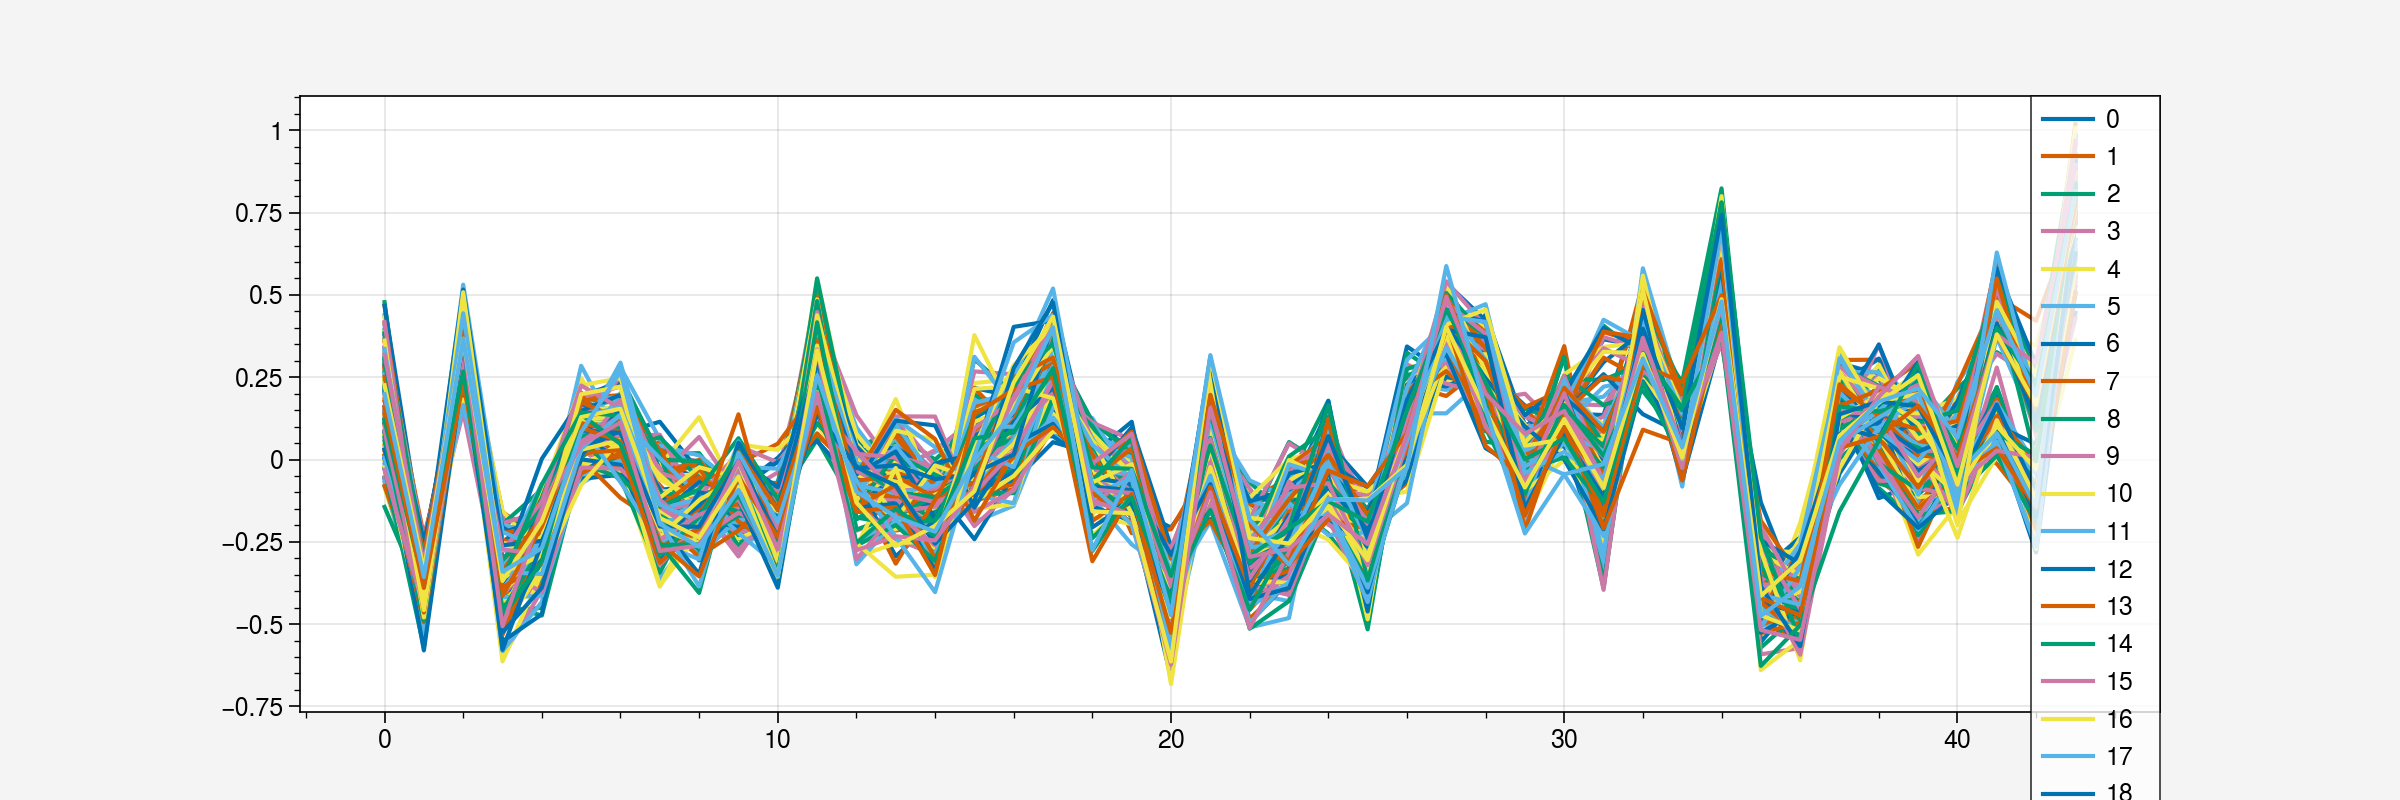

In [4]:
dynamic_t2m_ano_all_weighted_ts_all = xr.concat([dynamic_t2m_ano_all_weighted_ts_all_era5,dynamic_t2m_ano_all_weighted_ts_all_jra55],dim='schemes')
dynamic_t2m_ano_all_weighted_ts_daily_all_era5['target_time'] = dynamic_t2m_ano_all_weighted_ts_daily_all_jra55['target_time']
dynamic_t2m_ano_all_weighted_ts_daily_all = xr.concat([dynamic_t2m_ano_all_weighted_ts_daily_all_era5,dynamic_t2m_ano_all_weighted_ts_daily_all_jra55],dim='schemes')
df = pd.DataFrame(dynamic_t2m_ano_all_weighted_ts_all.values.transpose())
df.plot(figsize=(12,4))

In [5]:
t2m_summer_all = xr.open_dataarray('data/t2m_summer_1979_2022.nc')
t2m_summer_1979_2010 = t2m_summer_all.sel(time=slice(1979,2010))
t2m_summer_1979_2010_clim_mean = t2m_summer_1979_2010.mean(axis=2)
t2m_summer_ano = t2m_summer_all - t2m_summer_1979_2010_clim_mean
t2m_summer_ano = t2m_summer_ano.sel(latitude = slice(35,25),longitude = slice(100,122.5))
weights = np.cos(np.deg2rad(t2m_summer_ano.latitude))
weights.name = 'weights'
t2m_summer_ano_weighted = t2m_summer_ano.weighted(weights)
t2m_summer_ano_ts_era5 = t2m_summer_ano_weighted.mean(('longitude','latitude'))

t2m_summer_all = xr.open_dataarray('data/t2m_summer_1979_2022_jra55.nc')
t2m_summer_1979_2010 = t2m_summer_all.sel(time=slice(1979,2010))
t2m_summer_1979_2010_clim_mean = t2m_summer_1979_2010.mean(axis=2)
t2m_summer_ano = t2m_summer_all - t2m_summer_1979_2010_clim_mean
t2m_summer_ano = t2m_summer_ano.sel(lat = slice(35,25),lon = slice(100,122.5))
weights = np.cos(np.deg2rad(t2m_summer_ano.lat))
weights.name = 'weights'
t2m_summer_ano_weighted = t2m_summer_ano.weighted(weights)
t2m_summer_ano_ts_jra55 = t2m_summer_ano_weighted.mean(('lon','lat'))

In [6]:
t2m_obs_ano_historical_era5 = xr.open_dataarray('data/T2m_5day_running_anomalies_era5_D1_1979_2022_MJJAS.nc')
t2m_obs_ano_historical_era5 = t2m_obs_ano_historical_era5.sel(lat = slice(35,25),lon = slice(100,122.5))
weights = np.cos(np.deg2rad(t2m_obs_ano_historical_era5.lat))
weights.name = 'weights'
t2m_obs_ano_historical_era5_weighted = t2m_obs_ano_historical_era5.weighted(weights)
t2m_obs_ano_historical_era5_weighted_ts = t2m_obs_ano_historical_era5_weighted.mean(('lon','lat'))
t2m_obs_ano_historical_era5_weighted_ts = t2m_obs_ano_historical_era5_weighted_ts.sel(time = t2m_obs_ano_historical_era5_weighted_ts.time.dt.month.isin(range(6,9)))
t2m_obs_ano_historical_era5_weighted_ts_daily = t2m_obs_ano_historical_era5_weighted_ts
t2m_obs_ano_historical_era5_weighted_ts = t2m_obs_ano_historical_era5_weighted_ts.groupby('time.year').mean()

t2m_obs_ano_historical_jra55 = xr.open_dataarray('data/T2m_5day_running_anomalies_jra55_D1_1979_2022_MJJAS.nc')
t2m_obs_ano_historical_jra55 = t2m_obs_ano_historical_jra55.sel(lat = slice(35,25),lon = slice(100,122.5))
weights = np.cos(np.deg2rad(t2m_obs_ano_historical_jra55.lat))
weights.name = 'weights'
t2m_obs_ano_historical_jra55_weighted = t2m_obs_ano_historical_jra55.weighted(weights)
t2m_obs_ano_historical_jra55_weighted_ts = t2m_obs_ano_historical_jra55_weighted.mean(('lon','lat'))
t2m_obs_ano_historical_jra55_weighted_ts = t2m_obs_ano_historical_jra55_weighted_ts.sel(time = t2m_obs_ano_historical_jra55_weighted_ts.time.dt.month.isin(range(6,9)))
t2m_obs_ano_historical_jra55_weighted_ts_daily = t2m_obs_ano_historical_jra55_weighted_ts
t2m_obs_ano_historical_jra55_weighted_ts = t2m_obs_ano_historical_jra55_weighted_ts.groupby('time.year').mean()

t2m_obs_ano_historical_weighted_ts_daily = (t2m_obs_ano_historical_era5_weighted_ts_daily.values + t2m_obs_ano_historical_jra55_weighted_ts_daily.values)/2

t2m_obs_ano_historical_weighted_ts = (t2m_summer_ano_ts_era5 + t2m_summer_ano_ts_jra55) / 2

In [7]:
dynamic_t2m_ano_all_weighted_ts_daily_all_mean = dynamic_t2m_ano_all_weighted_ts_daily_all.mean(axis=0)
dynamic_t2m_ano_all_weighted_ts_daily_all_mean = dynamic_t2m_ano_all_weighted_ts_daily_all_mean.rename({'target_time':'time'})

from sklearn.metrics import explained_variance_score
explained_var = explained_variance_score(
    t2m_obs_ano_historical_weighted_ts_daily,
    dynamic_t2m_ano_all_weighted_ts_daily_all_mean)
print("Explained variance:", explained_var)

corr = np.corrcoef(
    [t2m_obs_ano_historical_weighted_ts_daily,
    dynamic_t2m_ano_all_weighted_ts_daily_all_mean])[0,1]
print("R square:", corr ** 2)

Explained variance: 0.6507194361689836
R square: 0.6584581640874658


In [8]:
df['schemes_mean'] = df.mean(axis=1)
df['obs'] = t2m_obs_ano_historical_weighted_ts
df['residual'] = df['obs'] - df['schemes_mean']

for i in range(120):
    df['res'+str(i)] = df['obs'] - df[i]

df.index = range(1979,2023)

In [10]:
hg.pettitt_test(x =df['obs'])

Pettitt_Test(h=True, cp=26, p=0.0001, U=360.0, avg=mean(mu1=-0.09339504862755905, mu2=0.587543625565308))

In [11]:
hg.pettitt_test(x =df['residual'])

Pettitt_Test(h=True, cp=19, p=0.0, U=405.0, avg=mean(mu1=-0.14136896012536537, mu2=0.4092510702896511))

In [12]:
def _compute_slope(var):
    if np.isnan(var).all():
        slp = np.nan
    else:
        slp = linregress(range(len(var)),var).slope
    return slp
    
def trend_cal(data):
        slopes = xr.apply_ufunc(_compute_slope,
                                data,
                                vectorize=True,
                                dask='parallelized', 
                                input_core_dims=[['time']],
                                output_dtypes=[float],
                                )
        return slopes

In [13]:
## calculate spatial trends in analogue and residual 
dynamic_t2m_ano_D1 = xr.open_dataarray('data/dynamic_t2m_historical/dynamic_t2m_era5_' + 'D1' + 'SLP.nc')
dynamic_t2m_ano_D2 = xr.open_dataarray('data/dynamic_t2m_historical/dynamic_t2m_era5_' + 'D2' + 'SLP.nc')
dynamic_t2m_ano_D3 = xr.open_dataarray('data/dynamic_t2m_historical/dynamic_t2m_era5_' + 'D3' + 'SLP.nc')
new_lon = dynamic_t2m_ano_D1.lon
new_lat = dynamic_t2m_ano_D1.lat
target_shape = dynamic_t2m_ano_D1.shape
dynamic_t2m_ano_D2_new = np.empty(target_shape[1:])
dynamic_t2m_ano_D2_new[:] = np.nan
dynamic_t2m_ano_D3_new = np.empty(target_shape[1:])
dynamic_t2m_ano_D3_new[:] = np.nan
dynamic_t2m_ano_all_hist = np.empty((60,44,)+target_shape[-2:])
dynamic_t2m_ano_all_hist[:] = np.nan

for i in range(target_shape[0]):
    dynamic_t2m_ano_D2_new[:,:,:,5:36,10:71] = dynamic_t2m_ano_D2.values[i]
    dynamic_t2m_ano_D2_new = xr.DataArray(
        data=dynamic_t2m_ano_D2_new,
        coords=[dynamic_t2m_ano_D1.dist_func,dynamic_t2m_ano_D1.every_other_5day,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
        dims = ['dist_func','every_other_5day','target_time','lat','lon'])
    dynamic_t2m_ano_D3_new[:,:,:,10:31,20:61] = dynamic_t2m_ano_D3.values[i]
    dynamic_t2m_ano_D3_new = xr.DataArray(
        data=dynamic_t2m_ano_D3_new,
        coords=[dynamic_t2m_ano_D1.dist_func,dynamic_t2m_ano_D1.every_other_5day,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
        dims = ['dist_func','every_other_5day','target_time','lat','lon'])

    dynamic_t2m_ano_all = np.empty((target_shape[1]*target_shape[2]*3,) + target_shape[-3:])
    dynamic_t2m_ano_all[:] = np.nan
    dynamic_t2m_ano_all[:20] = dynamic_t2m_ano_D1.values[i].reshape((20,)+target_shape[-3:])
    dynamic_t2m_ano_all[20:40] = dynamic_t2m_ano_D2_new.values.reshape((20,)+target_shape[-3:])
    dynamic_t2m_ano_all[40:] = dynamic_t2m_ano_D3_new.values.reshape((20,)+target_shape[-3:])
    schemes = range(target_shape[1]*target_shape[2]*3)
    dynamic_t2m_ano_all = xr.DataArray(
        data=dynamic_t2m_ano_all,
        coords=[schemes,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
        dims = ['schemes','target_time','lat','lon'])

    # dynamic_t2m_ano_all = dynamic_t2m_ano_all.sel(lat = slice(35,25),lon = slice(100,122.5))
    dynamic_t2m_ano_all = dynamic_t2m_ano_all.mean(axis=1) # summer mean
    dynamic_t2m_ano_all_hist[:,i,:,:] = dynamic_t2m_ano_all

historical_time = range(1979,2023)
dynamic_t2m_ano_all_hist = xr.DataArray(
    data = dynamic_t2m_ano_all_hist, 
    coords=[schemes, historical_time, dynamic_t2m_ano_D1.lat, dynamic_t2m_ano_D1.lon],
    dims=['schemes','time','lat','lon'])

dynamic_t2m_ano_all_hist_trend = trend_cal(dynamic_t2m_ano_all_hist)

t2m_obs_ano_historical = xr.open_dataarray('data/T2m_5day_running_anomalies_era5_D1_1979_2022_MJJAS.nc')
t2m_obs_ano_historical = t2m_obs_ano_historical.sel(time = t2m_obs_ano_historical.time.dt.month.isin(range(6,9)))
t2m_obs_ano_historical = t2m_obs_ano_historical.groupby('time.year').mean()
t2m_obs_ano_historical = t2m_obs_ano_historical.rename({'year':'time'})
residual_trend = trend_cal(t2m_obs_ano_historical) - dynamic_t2m_ano_all_hist_trend
residual_trend = residual_trend.transpose('schemes','lat','lon')

residual_contribution = residual_trend / trend_cal(t2m_obs_ano_historical) * 100
dynamic_t2m_ano_all_hist_trend_std = dynamic_t2m_ano_all_hist_trend.std(axis=0)
residual_trend_std = residual_trend.std(axis=0)
residual_contribution_std = residual_contribution.std(axis=0)

# plot historical changes in observed and constructed SAT anomalies

In [14]:
from descartes import PolygonPatch
import shapefile
import matplotlib.path as mpath
import matplotlib.patches as mpatches
source_path = 'shapefiles/country.shp'

Path = mpath.Path
sfile = shapefile.Reader(source_path)
for shape_rec in sfile.shapeRecords():
    vertices = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            vertices.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = mpath.Path(vertices, codes)
    clip = mpatches.PathPatch(clip,visible=False,transform=ccrs.PlateCarree())

Changes in residual:
       trend:0.023
       pval:0.0
       intercept:-45.76
       1.96 std:0.003
Changes in dynamic:
       trend:0.006
       pval:0.0537
       intercept:-12.01
       1.96 std:0.003
Changes in observation:
       trend:0.029
       pval:0.0
       intercept:-57.77
       1.96 std:0.0048
Before 1998 mean SAT anomalies: -0.14
Before 1998 median SAT anomalies: -0.18
After 1998 mean SAT anomalies: 0.41
After 1998 median SAT anomalies: 0.4


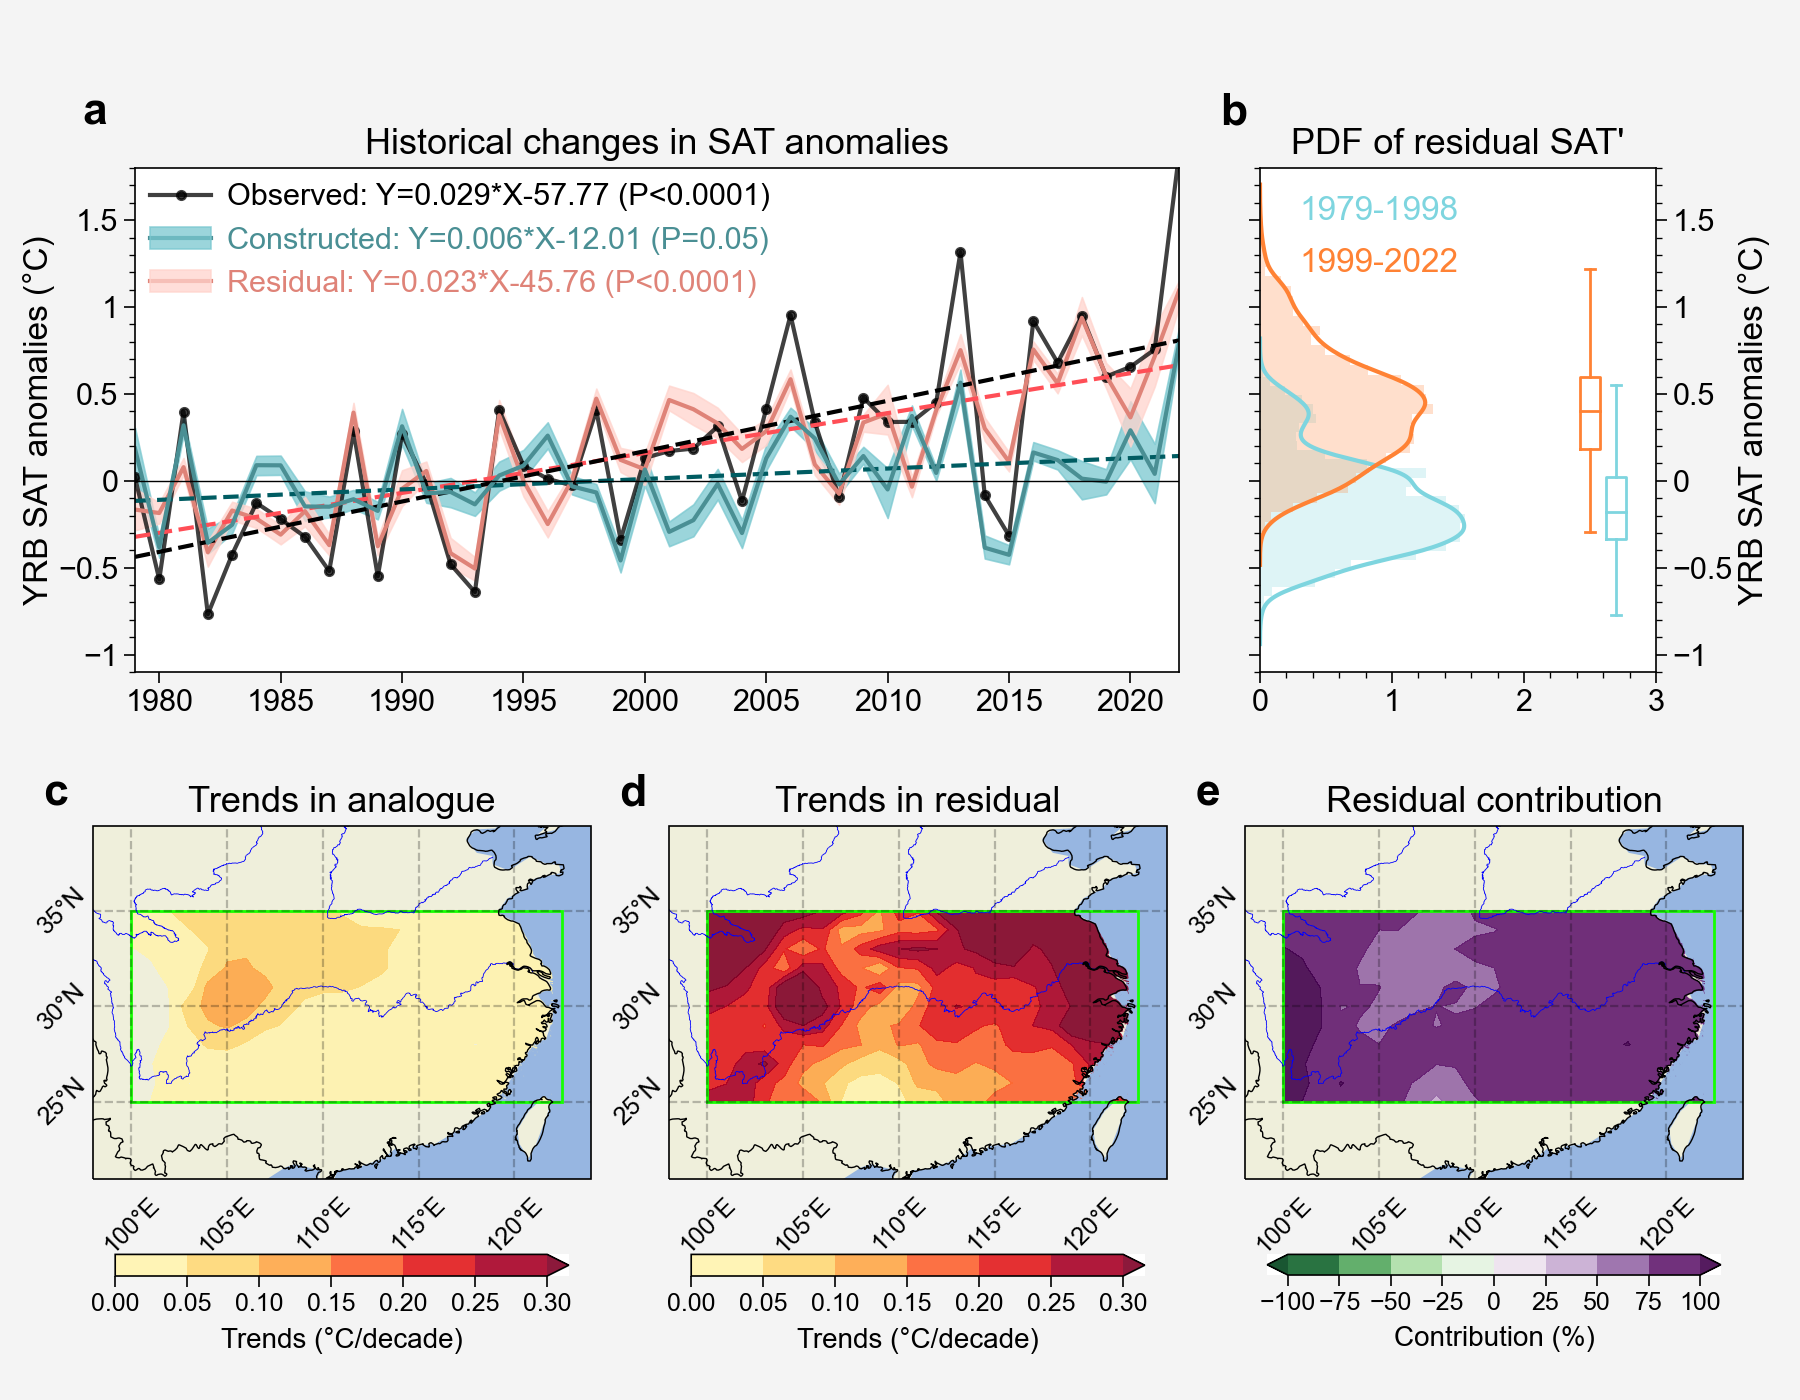

In [18]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
from copy import copy
plt.rcParams["font.family"] = "Arial"

axes_locs = [
    [0.075,0.52,0.58,0.36],
    [0.70,0.52,0.22,0.36],
    [0.05,0.05,0.28,0.36],
    [0.37,0.05,0.28,0.36],
    [0.69,0.05,0.28,0.36],
]

fig = plt.figure(figsize = (9,7))
# ax1 for historical observation versus CCA constructed anomalies, and their residuals
ax1 = fig.add_axes(axes_locs[0])
trend_res = linregress(df.index,df['residual']).slope
pval_res = linregress(df.index,df['residual']).pvalue
intercept_res = linregress(df.index,df['residual']).intercept
stderr_res = linregress(df.index,df['residual']).stderr
print('Changes in residual:')
print('       trend:' + str(round(trend_res,4)))
print('       pval:' + str(round(pval_res,4)))
print('       intercept:' + str(round(intercept_res,2)))
print('       1.96 std:' + str(round(stderr_res,4)))
trend_dyn = linregress(df.index,df['schemes_mean']).slope
pval_dyn = linregress(df.index,df['schemes_mean']).pvalue
intercept_dyn = linregress(df.index,df['schemes_mean']).intercept
stderr_dyn = linregress(df.index,df['schemes_mean']).stderr
print('Changes in dynamic:')
print('       trend:' + str(round(trend_dyn,4)))
print('       pval:' + str(round(pval_dyn,4)))
print('       intercept:' + str(round(intercept_dyn,2)))
print('       1.96 std:' + str(round(stderr_dyn,4)))
trend_obs = linregress(df.index,df['obs']).slope
pval_obs = linregress(df.index,df['obs']).pvalue
intercept_obs = linregress(df.index,df['obs']).intercept
stderr_obs = linregress(df.index,df['obs']).stderr
print('Changes in observation:')
print('       trend:' + str(round(trend_obs,4)))
print('       pval:' + str(round(pval_obs,4)))
print('       intercept:' + str(round(intercept_obs,2)))
print('       1.96 std:' + str(round(stderr_obs,4)))

l1 = ax1.plot(df['obs'], color='black', linewidth=1.5,alpha=0.75,marker='.')
# ax1.scatter(df.index, df['obs'], color='black', marker='.',alpha=0.75)
l3 = ax1.plot(df['residual'], color = '#df8378', linewidth=1.5)
ax1.plot(df.index, df.index * trend_res + intercept_res, '--', color = '#ff4e56')
ax1.plot(df.index, df.index * trend_dyn + intercept_dyn, '--', color = '#005c62')
ax1.plot(df.index, df.index * trend_obs + intercept_obs, '--', color = 'black')
l2 = ax1.plot(df['schemes_mean'], color = '#4a8f94', linewidth=1.5)
f2 = ax1.fill_between(x=df.index,y1=df.iloc[:,:120].quantile(0.25,axis=1),y2=df.iloc[:,:120].quantile(0.75,axis=1),alpha=0.75,color='#7ac8d0')
f3 = ax1.fill_between(x=df.index,y1=df.iloc[:,-120:].quantile(0.25,axis=1),y2=df.iloc[:,-120:].quantile(0.75,axis=1),alpha=0.75,color='#ffd4cd')
ax1.axhline(y=0, linewidth=0.5, linestyle='-', color='black')
ax1.set_ylabel('YRB SAT anomalies (°C)',fontdict={'fontsize':12},labelpad=1)
ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax1.tick_params(axis='x',labelsize=11)
ax1.tick_params(axis='y',labelsize=11)
ax1.set_xlim((1979,2022))
ax1.set_ylim((-1.1,1.8))
ax1.grid(False)
ax1.set_title('Historical changes in SAT anomalies',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
s1 = 'Y=' + str(round(trend_obs,3)) + '*X' + str(round(intercept_obs,2)) + ' (P<0.0001)'
s2 = 'Y=' + str(round(trend_dyn,3)) + '*X' + str(round(intercept_dyn,2)) + ' (P=' + str(round(pval_dyn,2)) + ')'
s3 = 'Y=' + str(round(trend_res,3)) + '*X' + str(round(intercept_res,2)) + ' (P<0.0001)'
leg = ax1.legend([l1[0],(l2[0],f2),(l3[0],f3)], ['Observed: '+ s1,'Constructed: '+ s2,'Residual: '+ s3],ncol=1,fontsize=11,loc='upper left',frameon=False)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

# ax2 for PDF of residual before and after the abrupt change point [2004]
import seaborn as sns
ax2 = fig.add_axes(axes_locs[1])
sns.distplot(a=pd.DataFrame({'before_1998':df.iloc[:19,-120:].to_numpy().reshape((19*120))}), kde=True,color='#7ed5df',hist_kws={'alpha':0.25}, vertical=True, ax = ax2)
sns.distplot(a=pd.DataFrame({'after_1998':df.iloc[19:,-120:].to_numpy().reshape((25*120))}), kde=True,color='#ff8234',hist_kws={'alpha':0.25}, vertical=True, ax = ax2)

boxprops1 = dict(linestyle='-', linewidth=1, color='#7ed5df')
boxprops2 = dict(linestyle='-', linewidth=1, color='#ff8234')
whiskerprops1 = dict(linestyle='-', linewidth=1, color='#7ed5df')
whiskerprops2 = dict(linestyle='-', linewidth=1, color='#ff8234')
capprops1 = dict(linestyle='-', linewidth=1, color='#7ed5df')
capprops2 = dict(linestyle='-', linewidth=1, color='#ff8234')
medianprops1 = dict(linestyle='-', linewidth=1, color='#7ed5df')
medianprops2 = dict(linestyle='-', linewidth=1, color='#ff8234')
ax2.boxplot(x = pd.DataFrame({'before_1998':df.iloc[:19,-120:].to_numpy().reshape((19*120))}), vert=True, positions=[2.7],widths=0.15,showfliers=False,boxprops=boxprops1,whiskerprops=whiskerprops1,capprops=capprops1,medianprops=medianprops1)
ax2.boxplot(x = pd.DataFrame({'after_1998':df.iloc[19:,-120:].to_numpy().reshape((25*120))}), vert=True, positions=[2.5],widths=0.15,showfliers=False,boxprops=boxprops2,whiskerprops=whiskerprops2,capprops=capprops2,medianprops=medianprops2)

ax2.set_xlim((0,3))
ax2.set_ylim((-1.1,1.8))
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels([0,1,2,3])
ax2.tick_params(axis='x',labelsize=11)
ax2.tick_params(axis='y',labelsize=11)
ax2.xaxis.label.set_visible(False)  # remove xlabel
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=True)
ax2.yaxis.set_ticks_position('both')
ax2.set_ylabel('YRB SAT anomalies (°C)',fontdict={'fontsize':12},labelpad=2)
ax2.yaxis.set_label_position("right")
ax2.text(s='1979-1998',x = 0.3, y=1.5,fontdict={'fontsize':12,'color':'#7ed5df','fontweight':'medium'})
ax2.text(s='1999-2022',x = 0.3, y=1.2,fontdict={'fontsize':12,'color':'#ff8234','fontweight':'medium'})
ax2.set_title('PDF of residual SAT\'',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
ax2.grid(False)

print('Before 1998 mean SAT anomalies: ' + str(round(df.iloc[:19,-120:].to_numpy().reshape((19*120)).mean(),2)))
print('Before 1998 median SAT anomalies: ' + str(round(np.median(df.iloc[:19,-120:].to_numpy().reshape((19*120))),2)))
print('After 1998 mean SAT anomalies: ' + str(round(df.iloc[19:,-120:].to_numpy().reshape((25*120)).mean(),2)))
print('After 1998 median SAT anomalies: ' + str(round(np.median(df.iloc[19:,-120:].to_numpy().reshape((25*120))),2)))

#ax3 for spatial distribution of trends in analogue
mapcrs = ccrs.PlateCarree()
ax3 = fig.add_axes(axes_locs[2],projection=mapcrs)
clip_copy = copy(clip)
ax3.add_patch(clip_copy)
river = shpreader.Reader('shapefiles/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.3)
ax3.add_feature(cfeature.LAND.with_scale('110m'))
ax3.add_feature(cfeature.OCEAN.with_scale('110m'))
ax3.add_feature(river_feature)
ax3.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,))
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)
dynamic_t2m_ano_all_hist_trend_YRB = dynamic_t2m_ano_all_hist_trend.sel(lat = slice(35,25),lon = slice(100,122.5))
dynamic_t2m_ano_all_hist_trend_YRB = dynamic_t2m_ano_all_hist_trend_YRB.mean(axis=0) * 10
lon = dynamic_t2m_ano_all_hist_trend_YRB['lon']
lat = dynamic_t2m_ano_all_hist_trend_YRB['lat']
p3 = ax3.contourf(lon, lat, dynamic_t2m_ano_all_hist_trend_YRB, cmap=cmaps.MPL_YlOrRd, levels=[0,0.05,0.1,0.15,0.2,0.25,0.3],extend = 'max', transform=ccrs.PlateCarree(),alpha=0.9)
for c in p3.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

ax3.set_title('Trends in analogue',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
fig_cbar = fig.colorbar(p3, ax=ax3, location='bottom', shrink = 0.9, extend = 'max')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Trends (°C/decade)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl1 = ax3.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.25, linestyle='--', draw_labels=True)
ax3.set_extent([98, 124, 21, 39])
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
gl1.ylocator = mticker.FixedLocator([25,30,35])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'rotation': 45, 'ha':'center'}
gl1.ylabel_style = {'rotation': 45, 'ha':'center'}
gl1.right_labels = False
gl1.top_labels = False

#ax4 for spatial distribution of trends in residual
mapcrs = ccrs.PlateCarree()
ax4 = fig.add_axes(axes_locs[3],projection=mapcrs)
clip_copy = copy(clip)
ax4.add_patch(clip_copy)
ax4.add_feature(cfeature.LAND.with_scale('110m'))
ax4.add_feature(cfeature.OCEAN.with_scale('110m'))
ax4.add_feature(river_feature)
ax4.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,))
draw_map(china,color='black',linewidth=0.5)
residual_trend_YRB = residual_trend.sel(lat = slice(35,25),lon = slice(100,122.5))
residual_trend_YRB = residual_trend_YRB.mean(axis=0) * 10
lon = residual_trend_YRB['lon']
lat = residual_trend_YRB['lat']
p4 = ax4.contourf(lon, lat, residual_trend_YRB, cmap=cmaps.MPL_YlOrRd, levels=[0,0.05,0.1,0.15,0.2,0.25,0.3],extend = 'max', transform=ccrs.PlateCarree(),alpha=0.9)
for c in p4.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

ax4.set_title('Trends in residual',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
fig_cbar = fig.colorbar(p4, ax=ax4, location='bottom', shrink = 0.9, extend = 'max')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Trends (°C/decade)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl1 = ax4.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.25, linestyle='--', draw_labels=True)
ax4.set_extent([98, 124, 21, 39])
gl1.ylocator = mticker.FixedLocator([25,30,35])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'rotation': 45, 'ha':'center'}
gl1.ylabel_style = {'rotation': 45, 'ha':'center'}
gl1.right_labels = False
gl1.top_labels = False

#ax5 for spatial distribution of residual contribution
ax5 = fig.add_axes(axes_locs[4],projection=mapcrs)
clip_copy = copy(clip)
ax5.add_patch(clip_copy)
ax5.add_feature(cfeature.LAND.with_scale('110m'))
ax5.add_feature(cfeature.OCEAN.with_scale('110m'))
ax5.add_feature(river_feature)
ax5.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,))
draw_map(china,color='black',linewidth=0.5)
residual_contribution_YRB = residual_contribution.sel(lat = slice(35,25),lon = slice(100,122.5))
residual_contribution_YRB = residual_contribution_YRB.mean(axis=0)
lon = residual_contribution_YRB['lon']
lat = residual_contribution_YRB['lat']
p5 = ax5.contourf(lon, lat, residual_contribution_YRB, cmap=cmaps.MPL_PRGn_r, levels=[-100,-75,-50,-25,0,25,50,75,100],extend = 'both', transform=ccrs.PlateCarree(),alpha=0.9)
for c in p5.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

ax5.set_title('Residual contribution',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
fig_cbar = fig.colorbar(p5, ax=ax5, location='bottom', shrink = 0.9, extend = 'both')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Contribution (%)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl1 = ax5.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.25, linestyle='--', draw_labels=True)
ax5.set_extent([98, 124, 21, 39])
gl1.ylocator = mticker.FixedLocator([25,30,35])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'rotation': 45, 'ha':'center'}
gl1.ylabel_style = {'rotation': 45, 'ha':'center'}
gl1.right_labels = False
gl1.top_labels = False

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='left')

add_panel_label(ax1, 'a', x=-0.05, y = 1.15)
add_panel_label(ax2, 'b', x=-0.1, y = 1.15)
add_panel_label(ax3, 'c', x=-0.1, y = 1.15)
add_panel_label(ax4, 'd', x=-0.1, y = 1.15)
add_panel_label(ax5, 'e', x=-0.1, y = 1.15)

plt.tight_layout(pad=0)
fig.savefig("Figures/FigS6_historical_CCA_construct_SLP.pdf",bbox_inches='tight',pad_inches = 0)
fig.savefig('Figures/FigS6_historical_CCA_construct_SLP.png',bbox_inches='tight',pad_inches = 0)

# plot the standard deviation of the trends

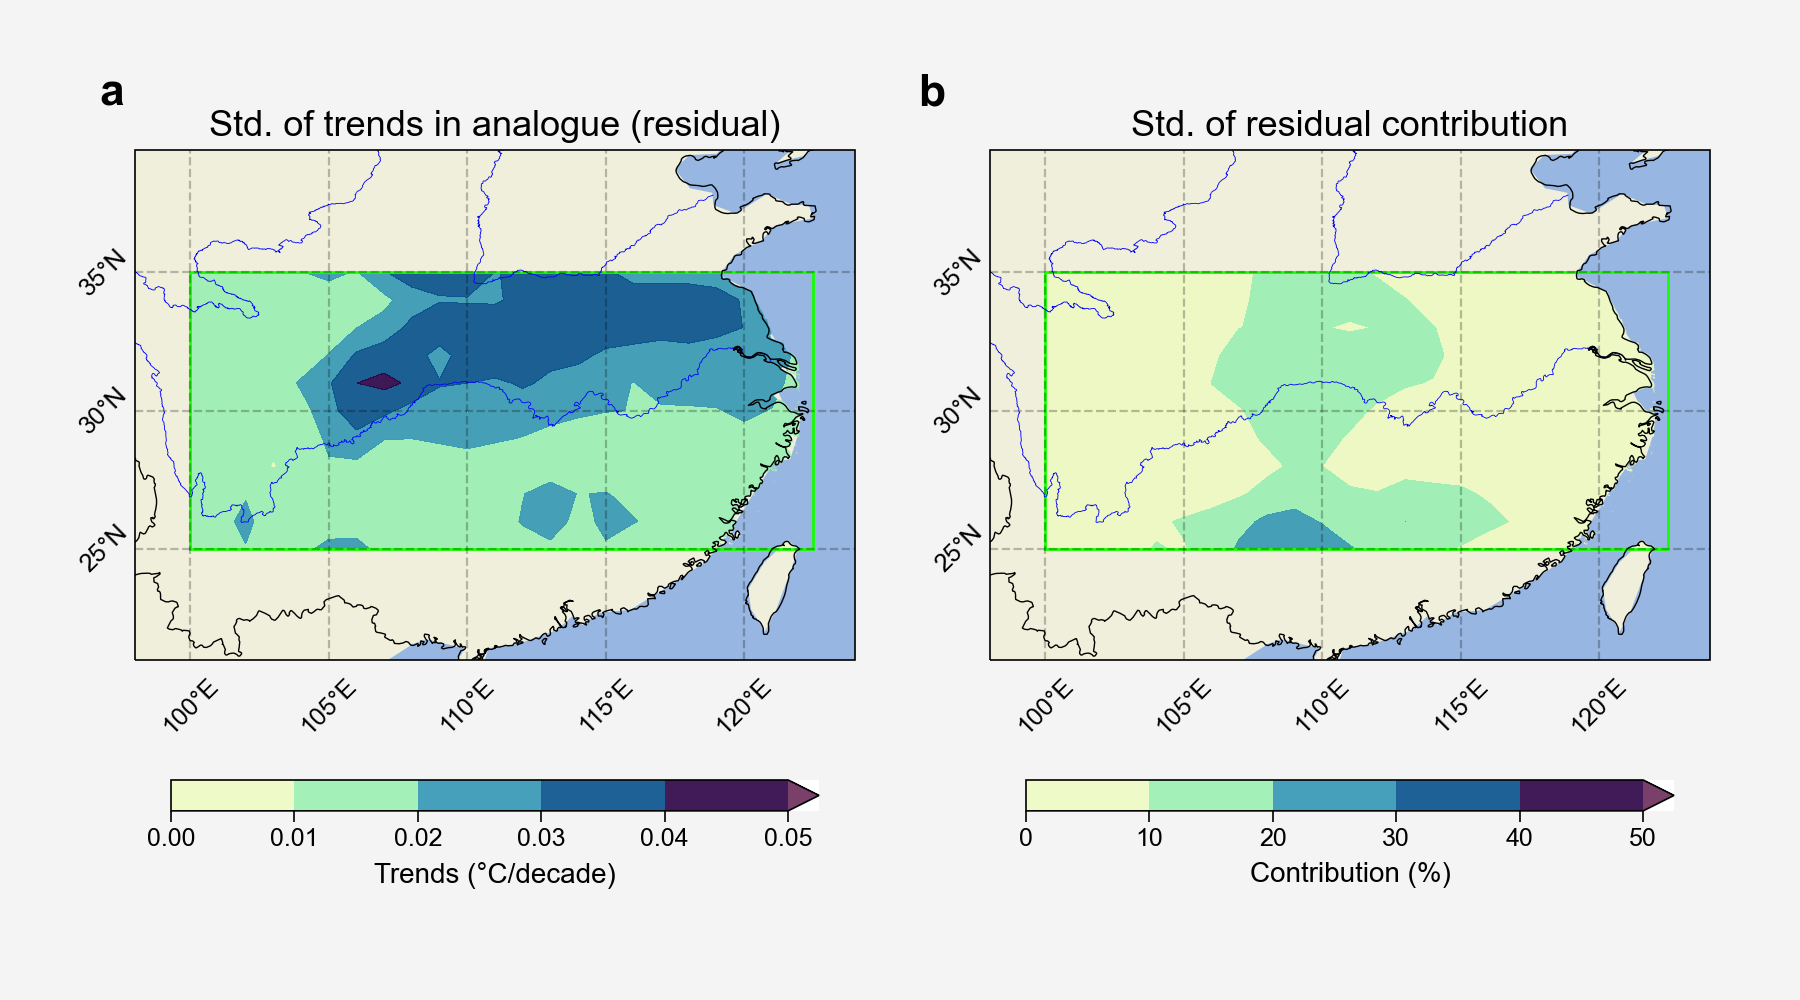

In [13]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
from copy import copy
plt.rcParams["font.family"] = "Arial"

axes_locs = [
    [0.075,0.1,0.4,0.8],
    [0.55,0.1,0.4,0.8],
]
# axes_locs = [
#     [0.075,0.52,0.45,0.4],
#     [0.55,0.52,0.45,0.4],
#     [0.35,0.05,0.45,0.4],
# ]

fig = plt.figure(figsize = (9,5))

# ax1 for standard deviation of the changes in analogue
mapcrs = ccrs.PlateCarree()
ax1 = fig.add_axes(axes_locs[0],projection=mapcrs)
clip_copy = copy(clip)
ax1.add_patch(clip_copy)
river = shpreader.Reader('shapefiles/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.3)
ax1.add_feature(cfeature.LAND.with_scale('110m'))
ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
ax1.add_feature(river_feature)
ax1.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,))
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)
dynamic_t2m_ano_all_hist_trend_std_YRB = dynamic_t2m_ano_all_hist_trend_std.sel(lat = slice(35,25),lon = slice(100,122.5))
dynamic_t2m_ano_all_hist_trend_std_YRB = dynamic_t2m_ano_all_hist_trend_std_YRB * 10
lon = dynamic_t2m_ano_all_hist_trend_std_YRB['lon']
lat = dynamic_t2m_ano_all_hist_trend_std_YRB['lat']
p1 = ax1.contourf(lon, lat, dynamic_t2m_ano_all_hist_trend_std_YRB, cmap=cmaps.precip_11lev, levels=[0,0.01,0.02,0.03,0.04,0.05],extend = 'max', transform=ccrs.PlateCarree(),alpha=0.9)
for c in p1.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

ax1.set_title('Std. of trends in analogue (residual)',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
fig_cbar = fig.colorbar(p1, ax=ax1, location='bottom', shrink = 0.9, extend = 'max')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Trends (°C/decade)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.25, linestyle='--', draw_labels=True)
ax1.set_extent([98, 124, 21, 39])
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
gl1.ylocator = mticker.FixedLocator([25,30,35])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'rotation': 45, 'ha':'center'}
gl1.ylabel_style = {'rotation': 45, 'ha':'center'}
gl1.right_labels = False
gl1.top_labels = False

# ax3 for standard deviation of the changes in residual contribution
ax3 = fig.add_axes(axes_locs[1],projection=mapcrs)
clip_copy = copy(clip)
ax3.add_patch(clip_copy)
ax3.add_feature(cfeature.LAND.with_scale('110m'))
ax3.add_feature(cfeature.OCEAN.with_scale('110m'))
ax3.add_feature(river_feature)
ax3.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,))
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)
residual_contribution_std_YRB = residual_contribution_std.sel(lat = slice(35,25),lon = slice(100,122.5))
residual_contribution_std_YRB = residual_contribution_std_YRB
lon = residual_contribution_std_YRB['lon']
lat = residual_contribution_std_YRB['lat']
p3 = ax3.contourf(lon, lat, residual_contribution_std_YRB, cmap=cmaps.precip_11lev, levels=[0,10,20,30,40,50],extend = 'max', transform=ccrs.PlateCarree(),alpha=0.9)
for c in p3.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

ax3.set_title('Std. of residual contribution',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
fig_cbar = fig.colorbar(p3, ax=ax3, location='bottom', shrink = 0.9, extend = 'max')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Contribution (%)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.25, linestyle='--', draw_labels=True)
ax3.set_extent([98, 124, 21, 39])
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
gl3.ylocator = mticker.FixedLocator([25,30,35])
gl3.xformatter = LONGITUDE_FORMATTER
gl3.yformatter = LATITUDE_FORMATTER
gl3.xlabel_style = {'rotation': 45, 'ha':'center'}
gl3.ylabel_style = {'rotation': 45, 'ha':'center'}
gl3.right_labels = False
gl3.top_labels = False

add_panel_label(ax1, 'a', x=-0.05, y = 1.15)
add_panel_label(ax3, 'b', x=-0.1, y = 1.15)

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.margins(0.015, tight=True)
# plt.tight_layout(pad=0)
fig.savefig("Figures/FigS3_historical_CCA_construct_std_SLP.pdf",bbox_inches='tight',pad_inches = 0)
fig.savefig('Figures/FigS3_historical_CCA_construct_std_SLP.png',bbox_inches='tight',pad_inches = 0)